In [33]:
import numpy as np
import scipy.signal
import scipy.stats
import tensorflow as tf
import matplotlib.pyplot as plt

from latent_dynamics import *
from variational import *
from normalizing_flow import *

from tqdm import tqdm

In [34]:
def DynamicMultiLayerPerceptron(x, in_dim, out_dim, time, gather=True):
    n_input = x.shape[0].value
    x_expand = tf.reshape(x, [time * n_input, in_dim])
    output_expand = MultiLayerPerceptron(
        x_expand, layers=[256, 256, out_dim]).get_output_layer()
    if gather:
        output_gather = tf.reshape(output_expand, [n_input, time * out_dim])
        return output_gather
    else:
        return x_expand

In [35]:
class DynamicalSystemVisualizer(object):

    def __init__(self, dim, time_steps):
        """Sets up the visualizer object.

        Parameters:
        -----------
        dim: int
            Dimensionality of the observation.
        time_steps: int
            Number of time steps in the dynamical system.
        """
        self.n_times = time_steps
        # Properties of latent and observation
        # Spaces.
        self.dim = dim
        self.set_up_figures()

    def set_up_figures(self):
        self.fig, self.ax = plt.subplots(1, self.dim + 1)
        self.fig.set_size_inches(5 * (self.dim + 1), 5)
        self.ctr = 0
        for i in range(self.dim):
            self.ax[i].set_xlabel('Time')
            self.ax[i].set_ylabel('Dim {}'.format(i + 1))
        self.ax[self.dim].set_xlabel('Dim 1')
        self.ax[self.dim].set_ylabel('Dim 2')

    def add_trajectory(self, trajectory, color, alpha=1.):
        """Adds a trajectory to the trajectories to be visualized."""
        if len(trajectory.shape) == 1:
            trajectory = trajectory[np.newaxis, :]
        shape = trajectory.shape
        if shape[1] == self.n_times * self.dim:
            for d in range(self.dim):
                sample = trajectory[:, d::self.dim]
                self.ax[d].plot(sample.T, color=color, alpha=alpha)
            for i in range(shape[0]):
                self.ax[self.dim].plot(
                    trajectory[i, ::self.dim], trajectory[i, 1::self.dim], color=color, alpha=alpha)

-0.15999999999999998


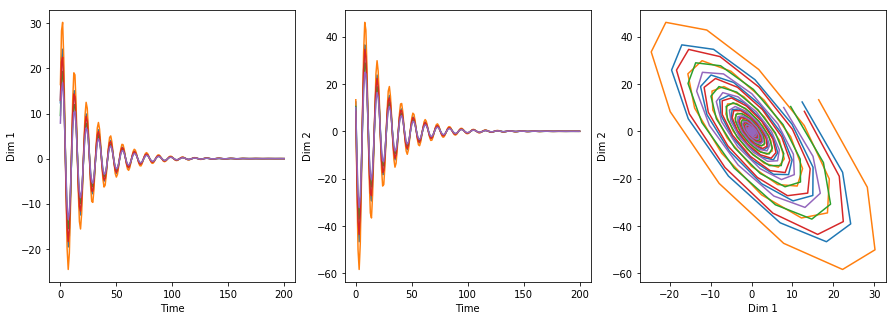

In [36]:
TRANS_MATRIX = np.array([[.1, -.4], [.1, -.2]])
TRANS_MATRIX = np.array([[.1, -.4], [.1, -.2]]) * 4
#TRANS_MATRIX = np.array([[.25, .5], [.5, .25]])

time_ = 200

print np.power(np.trace(TRANS_MATRIX), 2) - np.linalg.det(TRANS_MATRIX) # Determinse the stability of the dynamics

def lin_dyn(x_not, t_mat, time, dt=0.001):
    l = [x_not]
    for i in range(time):
        l.append(l[-1] + np.matmul(l[-1], t_mat))
    return np.squeeze(np.array(l))

lin_vis = DynamicalSystemVisualizer(dim=2, time_steps=time_+1)
for i in range(5):
    init_point = np.random.normal(10, 3, 2)
    l = lin_dyn(init_point, TRANS_MATRIX, time_, dt=0.001)
    lin_vis.add_trajectory(l.flatten(), color='C{}'.format(i))

In [37]:
L = 10 # Number of samples for monte carlo estimate
N = 100
LAT_DIM = 2
OBS_DIM = 3
TIME = 10

In [38]:
with tf.Graph().as_default():
    t1 = Transform(LAT_DIM, LAT_DIM, initial_value=TRANS_MATRIX)
    #t1 = QTransform(LAT_DIM, LAT_DIM)
    trans = ConditionalRandomVariable(
        dim_x=LAT_DIM, dim_y=LAT_DIM, transform=t1, noise=.1)
    t2 = Transform(LAT_DIM, OBS_DIM, initial_value=np.array([[1., 2., 1.], [2., 1., 1.]]))
    emmit = ConditionalRandomVariable(
        dim_x=OBS_DIM, dim_y=LAT_DIM, transform=t2, noise=.25)
    seq = MarkovLatentDynamics(trans, emmit, TIME)
    samp = seq.sample(N)
    prob = seq.log_prob(samp[0], samp[1])
    print samp[0].shape, samp[1].shape
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        z_star, x_star = sess.run(samp)
        p = sess.run(prob)

(100, 20) (100, 30)


In [39]:
print p
print x_star.shape
print z_star.shape

[ 99.38173103  98.8694534   92.02711252  96.85102297  93.91284784
  96.53631852  96.94352531  94.54583649 100.68224805  98.86579368
 100.76240065  91.27701786  93.21821217  94.52281362  96.41025374
  96.86860286  98.38931761  97.88324435  96.5411708   88.94305122
 100.11444048  89.93485121  99.2928648   92.77309496  99.09730154
  95.0155802   98.36224433  96.50668761  97.48860495  98.17584664
  92.78498432  97.13978352 103.86453912 101.24736433  92.28909722
 100.28305755  99.69651632  90.98292091 100.79667911  95.70040253
  90.8158346   98.91617979 105.96190566  89.7855023   98.20049813
  92.56369427 105.006053    85.4153576   92.38366162  92.66542617
  96.46472757  85.05735669  90.84486786  99.06763379  95.65219814
  98.73379582  93.56146179  92.77500214 101.15269391  97.64461998
 102.13539555  90.99733842 102.23755919 104.75340344  84.35587098
  93.13019701  99.42745542  94.84963926  96.78982407  95.43438979
  93.43581431 103.90622186  94.75622435  86.31624324  98.87832202
  91.40418

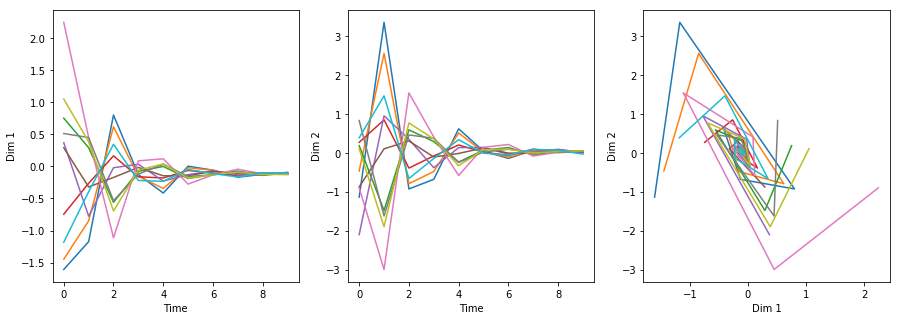

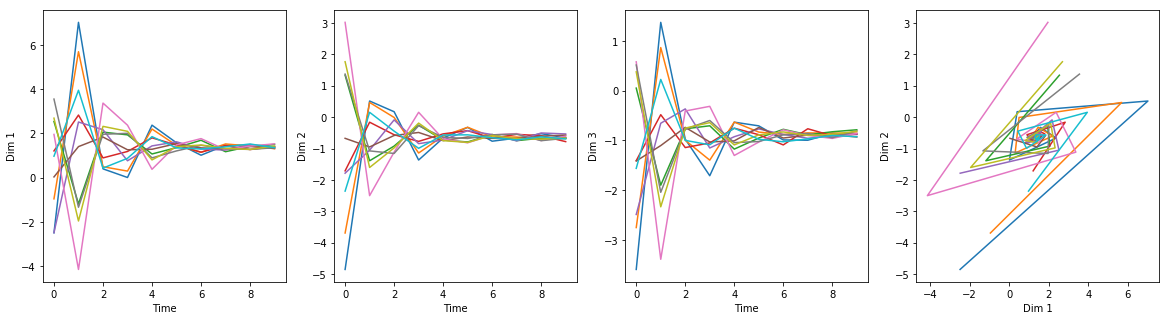

In [40]:
lin_vis_lat = DynamicalSystemVisualizer(dim=LAT_DIM, time_steps=TIME)
for i in range(L):
    lin_vis_lat.add_trajectory(z_star[i, :], color='C{}'.format(i))

lin_vis_obs = DynamicalSystemVisualizer(dim=OBS_DIM, time_steps=TIME)
for i in range(L):
    lin_vis_obs.add_trajectory(x_star[i, :], color='C{}'.format(i))

# Building Graph for Elbo Computation and Minimization

In [56]:
graph = tf.Graph()
tot_iterations = 0

with graph.as_default():

    # Observation
    x = tf.placeholder(shape=[1, OBS_DIM * TIME], dtype=tf.float64, name='input')

    # Variational Model
    rec = DynaFlowConditionalRandomVariable(y=x, dim=LAT_DIM, time=TIME, num_layers=5)

    # Generative Model
    # Transition Transformation
    # The following basically is the model for a kalman filter
    # with diagonal covariances
    t1 = Transform(LAT_DIM, LAT_DIM, initial_value=np.array([[1., .1], [.1, 1.]]))
    trans = ConditionalRandomVariable(
        dim_x=LAT_DIM, dim_y=LAT_DIM, transform=t1, noise=.5)
    # Emmision Transformation
    t2 = Transform(LAT_DIM, OBS_DIM)
    emmit = ConditionalRandomVariable(dim_x=OBS_DIM, dim_y=LAT_DIM, transform=t2)
    gen = MarkovLatentDynamics(trans, emmit, TIME)

    # Sample from variational for monte carlo
    sample, log_q = rec.sample_log_prob(10)

    loss = - tf.reduce_sum(gen.log_prob(sample, x)) + tf.reduce_sum(log_q)

    # Set up the learning algorithm
    train_op = tf.train.AdagradOptimizer(learning_rate=.1).minimize(loss)
    #train_op = tf.train.AdamOptimizer(learning_rate=.1).minimize(loss)

    z_d, x_d = gen.sample(L)

    losses = []
    # Learning
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

# Training The Models

In [57]:
STEPS = 10000

with graph.as_default():
    for i in tqdm(range(STEPS)):
        idx = i % N
        l, _ = sess.run(
            [loss, train_op],
            feed_dict={"input:0": x_star[np.newaxis, idx, :]})
        losses.append(l)
        tot_iterations += 1

100%|██████████| 10000/10000 [05:49<00:00, 28.64it/s]


# Let's Compute the Current Latent Paths and Reconstructions

In [51]:
outputs = []
with graph.as_default():
    for i in tqdm(range(N)):
        rec_, z_i, x_i = sess.run(
            [sample, z_d, x_d],
            feed_dict={"input:0": x_star[np.newaxis, i, :]})
        outputs.append([rec_, z_i, x_i])

100%|██████████| 100/100 [00:01<00:00, 89.74it/s]


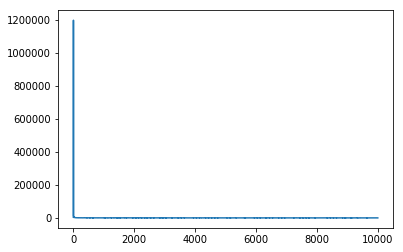

/home/hooshmand/Documents/VAE/gpuenv/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


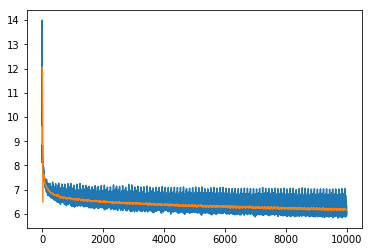

In [52]:
def smooth(x):
    return scipy.signal.savgol_filter(x, window_length=101, polyorder=3)

plt.plot(losses)
plt.show()

plt.plot(np.log(np.array(losses)))
plt.plot(np.log(np.array(smooth(losses))))
plt.show()

In [53]:
recs_ = np.squeeze(np.array([e[0] for e in outputs])[:, 0, :])
z_draw = np.squeeze(np.array([e[1] for e in outputs])[:, 0, :])
x_draw = np.squeeze(np.array([e[2] for e in outputs])[:, 0, :])

print recs_.shape, z_draw.shape, x_draw.shape

(100, 20) (100, 20) (100, 30)


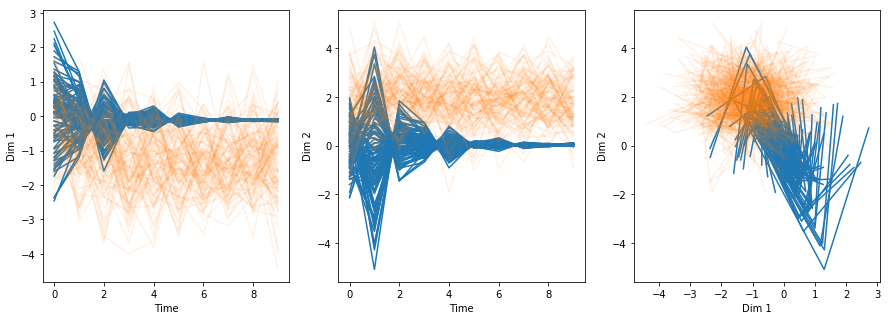

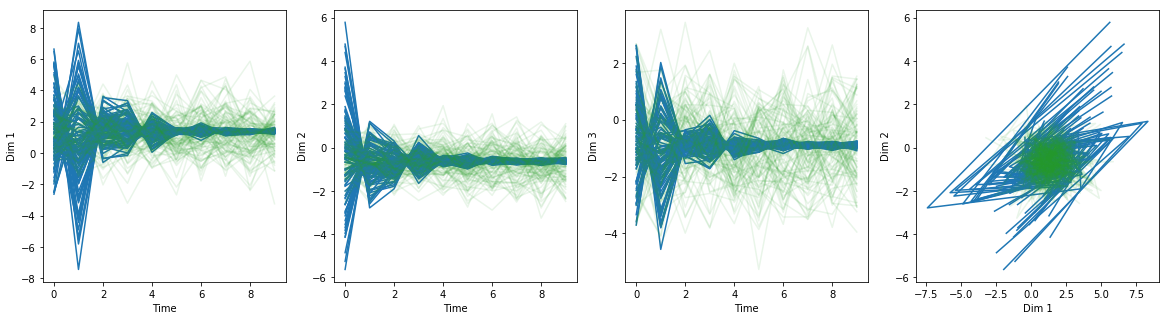

In [54]:
lin_vis_lat = DynamicalSystemVisualizer(dim=LAT_DIM, time_steps=TIME)
lin_vis_lat.add_trajectory(z_star[:, :], color='C0')
lin_vis_lat.add_trajectory(recs_, color='C1', alpha=0.1)
#lin_vis_lat.add_trajectory(np.squeeze(z_draw), color='C2', alpha=0.1)

lin_vis_obs = DynamicalSystemVisualizer(dim=OBS_DIM, time_steps=TIME)
lin_vis_obs.add_trajectory(x_star[:, :], color='C0')
lin_vis_obs.add_trajectory(np.squeeze(x_draw), color='C2', alpha=0.1)

In [58]:
sess.close()